In [18]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy.integrate as spi
import matplotlib
%matplotlib inline

## Single-patch simulations

In [4]:
# MODEL EQUATIONS (for numerical integration)
# INPUTS:
# y: array with initial conditions for S,B1,B2,AB1,AB2
# t: array with times at which evaluating the system
# alfa: infection rate of strain A
# beta: infection rate of B1
# delta: difference in infection rate between B2 and B1
# C: cooperative factor B1
# gamma: difference in cooperative factor between B2 and B1
# OUTPUT:
# array containing the values of S,B1,B2,AB1,AB2
# N.B. :
# A can be obtained by requiring S + B1 + B2 + A + AB1 + AB2 = 1
def SIS(y,t,alfa,beta,delta,C,gamma): 
    S,B1,B2,AB1,AB2 = y
    A = 1-S-B1-B2-AB1-AB2
    X1 = B1+AB1
    X2 = B2+AB2
    XA = A+AB1+AB2
    # equations
    f0 = -S*(alfa*XA+beta*X1+(beta+delta)*X2) + A + B1 + B2  #S
    f1 = AB1-B1-C*alfa*B1*XA+beta*S*X1 #B1
    f2 = AB2-B2-(C+gamma)*alfa*B2*XA+(beta+delta)*S*X2 #B2
    f3 = -2*AB1+C*alfa*B1*XA+C*beta*A*X1 #AB1
    f4 = -2*AB2+(C+gamma)*alfa*B2*XA+(C+gamma)*(beta+delta)*A*X2 #AB2
    return [f0,f1,f2,f3,f4]

Integrate equations defined in ```SIS``` function and plot prevalence for all pathogens 

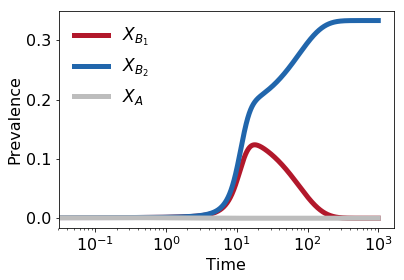

In [9]:
# model parameters
b1_test = 1.47
b2_test = 1.5
alfa_test = 0.6
C1_test = 4
C2_test = 2.5

# integrate dynamics
y0 = [0.997,0.001,0.001,0,0] #initial condition for S,B1,B2,AB1,AB2
t = np.linspace(0,1000,20000)
soln = spi.odeint(SIS, y0, t, args=(alfa_test, b1_test, b2_test-b1_test, C1_test, C2_test-C1_test))

X1 = np.array(soln[:,1]) + np.array(soln[:,3])  # get time series for B1's prevalence
X2 = np.array(soln[:,2]) + np.array(soln[:,4])  # get time series for B2's prevalence
XA = 1-np.array(soln[:,0])-np.array(soln[:,1])-np.array(soln[:,2]) # get time series for A's prevalence

# plot results
d_col = {'AB1':'#b2182b', 'AB2': '#2166ac', 'B2': '#92c5de'}

plt.plot(t,X1,color=d_col['AB1'],label=r'$X_{B_1}$', lw=5)
plt.plot(t,X2,color=d_col['AB2'],label=r'$X_{B_2}$', lw=5)
plt.plot(t,XA,color='#BDBDBD',label=r'$X_A$', lw=5)

plt.xscale('log')
plt.xlabel('Time',fontsize=16)
plt.ylabel('Prevalence',fontsize=16)

plt.legend(framealpha=False, fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=16)

In [17]:
#FULL JACOBIAN
#compute the jacobian for the previous system of equations
#INPUTS:
#y: steady state value
# alfa: infection rate of strain A
# beta: infection rate of B1
# delta: difference in infection rate between B2 and B1
# C: cooperative factor B1
# gamma: difference in cooperative factor between B2 and B1
#OUTPUT:
#5x5 jacobian computed for the desired stationary state

def Jacobian(y,alfa,beta,delta,C,gamma):
    # beta2 = beta1 + delta
    # C2 = C1 + gamma
    S,B1,B2,AB1,AB2 = y
    A = 1-S-B1-B2-AB1-AB2
    X1 = B1+AB1
    X2 = B2+AB2
    XA = A+AB1+AB2
    return np.array([[alfa*(S-XA)-1-beta*X1-(beta+delta)*X2,S*(alfa-beta),S*(alfa-beta-delta),-1-beta*S,-1-(beta+delta)*S],[C*alfa*B1+beta*X1,-1+C*alfa*(B1-XA)+beta*S,C*alfa*B1,1+beta*S,0],[(C+gamma)*alfa*B2+(beta+delta)*X2,(C+gamma)*alfa*B2,-1+alfa*(C+gamma)*(B2-XA)+(beta+delta)*S,0,1+(beta+delta)*S],[-C*(alfa*B1+beta*X1),C*beta*(1-S-2*X1-X2)+C*alfa*(XA-B1),-C*(alfa*B1+beta*X1),-2+C*beta*(1-S-2*X1-X2),-C*beta*X1],[-(C+gamma)*(alfa*B2+(beta+delta)*X2),-(C+gamma)*(alfa*B2+(beta+delta)*X2),(C+gamma)*(beta+delta)*(1-S-X1-2*X2)+(C+gamma)*alfa*(XA-B2),-(C+gamma)*(beta+delta)*X2,-2+(C+gamma)*(beta+delta)*(1-S-X1-2*X2)]])

#INVESTIGATE STABILITY
#The following functions take model's parameters as inputs and evaluate the Jacobian
#for a specific stationary state.
#OUTPUT:
#list with two elements: 
#the first element takes value 1 if the state is stable and 0 otherwise (unstable, or not feasible or does not exist)
#the second element is the leading Jacobian's eigenvalue if the state exists and is feasible (othrwise it's a NaN)

# [B1] state
def investigate_stability_B1(alfa,beta,delta,C1,gamma):
    if beta >= 1:
        SS = [1/beta,1-1/beta,0,0,0]
        ll = np.amax(LA.eig(Jacobian(SS,alfa,beta,delta,C1,gamma))[0])
        if ll < 0:
            return([1, ll])
        else:
            return([0,ll])
    else:
        return([0, np.nan])

# [B2] state
def investigate_stability_B2(alfa,beta,delta,C1,gamma):
    beta2 = beta + delta
    if beta2 >= 1:
        SS = [1/(beta2),0,1-1/(beta2),0,0]
        ll = np.amax(LA.eig(Jacobian(SS,alfa,beta,delta,C1,gamma))[0])
        if ll < 0:
            return([1, ll])
        else:
            return([0,ll])
    else:
        return([0, np.nan])

# [A&B1] state
def investigate_stability_AB1(alfa,beta,delta,C1,gamma):
    if beta >= 4*(1-1/C1)/(C1*alfa) and C1 > 1:
        S_steady = (1-np.sqrt(1-4*(1-1/C1)/(C1*alfa*beta)))/(2*(1-1/C1))
        B_steady = (1-alfa*S_steady)/(C1*alfa)
        A_steady = (1-beta*S_steady)/(C1*beta)
        Y_steady = 1 - S_steady - A_steady - B_steady
        tmp = [S_steady, B_steady, A_steady, Y_steady]
        if (np.amin(tmp) > 0 and np.amax(tmp) < 1):
            SS = [S_steady, B_steady, 0, Y_steady, 0]
            ll = np.amax(LA.eig(Jacobian(SS,alfa,beta,delta,C1,gamma))[0])
            if ll < 0:
                return([1, ll])
            else:
                return([0, ll])
        else:
            return([0, np.nan])
    else:
        return([0, np.nan])

# [A&B2] state
def investigate_stability_AB2(alfa,beta,delta,C1,gamma):
    beta2 = beta + delta
    C2 = C1 + gamma
    if beta2 >= 4*(1-1/C2)/(C2*alfa) and C2 > 1:
        S_steady = (1-np.sqrt(1-4*(1-1/C2)/(C2*alfa*beta2)))/(2*(1-1/C2))
        B_steady = (1-alfa*S_steady)/(C2*alfa)
        A_steady = (1-beta2*S_steady)/(C2*beta2)
        Y_steady = 1 - S_steady - A_steady - B_steady
        tmp = [S_steady, B_steady, A_steady, Y_steady]
        if (np.amin(tmp) > 0 and np.amax(tmp) < 1):
            SS = [S_steady, 0, B_steady, 0, Y_steady]
            ll = np.amax(LA.eig(Jacobian(SS,alfa,beta,delta,C1,gamma))[0])
            if ll < 0:
                return([1, ll])
            else:
                return([0, ll])
        else:
            return([0, np.nan])
    else:
        return([0, np.nan])

Investigate linear stability for a given set of parameters

In [16]:
b1_test = 1.47
b2_test = 1.5
alfa_test = 0.6
C1_test = 4
C2_test = 2.5

delta = b2_test - b1_test
gamma = C2_test - C1_test

#investigate B1
stable, ll = investigate_stability_B1(alfa_test,b1_test,delta,C1_test,gamma)
print('Is [B1] state stable? {}'.format(bool(stable)))

#investigate B2
stable, ll = investigate_stability_B2(alfa_test,b1_test,delta,C1_test,gamma)
print('Is [B2] state stable? {}'.format(bool(stable)))

#investigate A + B1
stable, ll = investigate_stability_AB1(alfa_test,b1_test,delta,C1_test,gamma)
print('Is [A&B1] state stable? {}'.format(bool(stable)))

#investigate A + B2
stable, ll = investigate_stability_AB2(alfa_test,b1_test,delta,C1_test,gamma)
print('Is [A&B2] state stable? {}'.format(bool(stable)))

Is [B1] state stable? False
Is [B2] state stable? True
Is [A&B1] state stable? True
Is [A&B2] state stable? False


# Two-patches simulations

In [19]:
# MODEL EQUATIONS (for numerical integration)
# INPUTS:
# y: array with initial conditions for S,B1,B2,AB1,AB2 in the first patch and in the second patch
# t: array with times at which evaluating the system
# alfa: infection rate of strain A
# beta: infection rate of B1
# delta: difference in infection rate between B2 and B1
# C: cooperative factor B1
# gamma: difference in cooperative factor between B2 and B1
# epsi: coupling between patches
# OUTPUT:
# array containing the values of S,B1,B2,AB1,AB2 in the first and in the second patch respectively

def SIS_2patches(y,t,alfa,beta,delta,C,gamma,epsi): 
    Sa,B1a,B2a,AB1a,AB2a,Sb,B1b,B2b,AB1b,AB2b = y
    
    Aa = 1-Sa-B1a-B2a-AB1a-AB2a
    X1a = B1a + AB1a
    X2a = B2a + AB2a
    XAa = Aa + AB1a + AB2a
    
    Ab = 1-Sb-B1b-B2b-AB1b-AB2b
    X1b = B1b + AB1b
    X2b = B2b + AB2b
    XAb = Ab + AB1b + AB2b
    
    # equations
    # 
    f0 = -Sa*(alfa*((1-epsi)*XAa+epsi*XAb)+beta*((1-epsi)*X1a+epsi*X1b)+(beta+delta)*((1-epsi)*X2a+epsi*X2b)) + Aa + B1a + B2a  #S
    f1 = AB1a-B1a-C*alfa*B1a*((1-epsi)*XAa+epsi*XAb)+beta*Sa*((1-epsi)*X1a+epsi*X1b) #B1
    f2 = AB2a-B2a-(C+gamma)*alfa*B2a*((1-epsi)*XAa+epsi*XAb)+(beta+delta)*Sa*((1-epsi)*X2a+epsi*X2b) #B2
    f3 = -2*AB1a+C*alfa*B1a*((1-epsi)*XAa+epsi*XAb)+C*beta*Aa*((1-epsi)*X1a+epsi*X1b) #AB1
    f4 = -2*AB2a+(C+gamma)*alfa*B2a*((1-epsi)*XAa+epsi*XAb)+(C+gamma)*(beta+delta)*Aa*((1-epsi)*X2a+epsi*X2b) #AB2
    
    f5 = -Sb*(alfa*((1-epsi)*XAb+epsi*XAa)+beta*((1-epsi)*X1b+epsi*X1a)+(beta+delta)*((1-epsi)*X2b+epsi*X2a)) + Ab + B1b + B2b  #S
    f6 = AB1b-B1b-C*alfa*B1b*((1-epsi)*XAb+epsi*XAa)+beta*Sb*((1-epsi)*X1b+epsi*X1a) #B1
    f7 = AB2b-B2b-(C+gamma)*alfa*B2b*((1-epsi)*XAb+epsi*XAa)+(beta+delta)*Sb*((1-epsi)*X2b+epsi*X2a) #B2
    f8 = -2*AB1b+C*alfa*B1b*((1-epsi)*XAb+epsi*XAa)+C*beta*Ab*((1-epsi)*X1b+epsi*X1a) #AB1
    f9 = -2*AB2b+(C+gamma)*alfa*B2b*((1-epsi)*XAb+epsi*XAa)+(C+gamma)*(beta+delta)*Ab*((1-epsi)*X2b+epsi*X2a) #AB2
    return [f0,f1,f2,f3,f4,f5,f6,f7,f8,f9]

Integrate equations defined in ```SIS_2patches``` function and plot prevalence of each pathogen in both patches

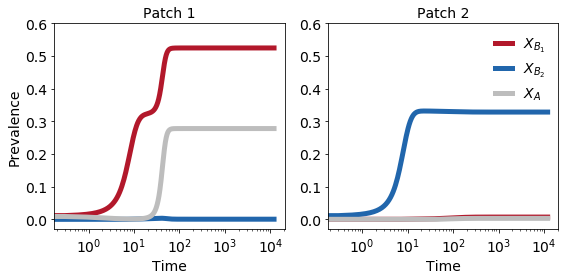

In [21]:
# choose parameters
b1 = 1.475 
b2 = 1.5
alfa = 0.6
C1 = 4
C2 = 2.9
epsilon = 0.0002

# integrate equations
y0 = [0.98,0.01,0,0,0,0.99,0,0.01,0,0] #initial condition for S,B1,B2,AB1,AB2
t = np.linspace(0,12000,40000) #list of times for ODE solver

soln = spi.odeint(SIS_2patches, y0, t, args=(alfa, b1, b2-b1, C1, C2-C1, epsilon))
X1ats = np.array(soln[:,1]) + np.array(soln[:,3])
X2ats = np.array(soln[:,2]) + np.array(soln[:,4])
XAats = 1-np.array(soln[:,0])-np.array(soln[:,1])-np.array(soln[:,2])

X1bts = np.array(soln[:,6]) + np.array(soln[:,8])
X2bts = np.array(soln[:,7]) + np.array(soln[:,9])
XAbts = 1-np.array(soln[:,5])-np.array(soln[:,6])-np.array(soln[:,7])


# plot prevalence in both patches
fig, ax = plt.subplots(ncols=2,figsize=(8,4))
cols = {'B1':'#b2182b', 'B2': '#2166ac', 'A': '#BDBDBD'}
lw = 5

ax[0].plot(t,X1ats,color=cols['B1'],label=r'$X_{B_1}$', lw=lw)
ax[0].plot(t,X2ats,color=cols['B2'],label=r'$X_{B_2}$', lw=lw)
ax[0].plot(t,XAats,color=cols['A'],label=r'$X_A$', lw=lw)

ax[1].plot(t,X1bts,color=cols['B1'],label=r'$X_{B_1}$', lw=lw)
ax[1].plot(t,X2bts,color=cols['B2'],label=r'$X_{B_2}$', lw=lw)
ax[1].plot(t,XAbts,color=cols['A'],label=r'$X_A$', lw=lw)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_ylim(-0.03, 0.6)
ax[1].set_ylim(-0.03, 0.6)

ax[0].set_xlabel('Time',fontsize=14)
ax[1].set_xlabel('Time',fontsize=14)

ax[0].set_ylabel('Prevalence',fontsize=14)
ax[1].legend(framealpha = False, fontsize=14, handlelength=1.2)
ax[0].set_title('Patch 1',fontsize=14)
ax[1].set_title('Patch 2',fontsize=14)

ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()